# Subscription Retention Analysis

## 0. Prerequisites

Import the important packages/library to be used

In [263]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns

from sbg_survival import SBGSurvival
from sbg_survival import ShiftedBetaGeometric

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

Importing the data (DSX code) (credentials are hidden)

In [229]:
# The code was removed by DSX for sharing.

In [230]:
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': name,'domain': {'id': id},
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f('Subscription', 'subscription.csv'))
df_data_1.head()


,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0



## 1. Data Facts

Compute simple statistics around the data (especially for the different sources, countries and price plan

In [231]:
user_count = len(df_data_1.user_id.unique())
print("there are " + str(user_count) + " subscribers at the start")

there are 500000 subscribers at the start


In [232]:
print(df_data_1.groupby(['subscription_monthly_cost']).size())

subscription_monthly_cost
29    146362
49    300397
99     53241
dtype: int64


In [233]:
print(df_data_1.groupby(['country']).size())

country
China      35938
France     51662
Germany    88944
India      48027
Italy      47459
Spain      44987
UK         91252
US         91731
dtype: int64


In [234]:
print(df_data_1.groupby(['source']).size())

source
ads                414469
friend_referral     24428
seo                 61103
dtype: int64


After we look at the individual variables, we would like to know if there is any interesting interactions between variables. Things we found for example is that China and India have significantly more subscribers with price plan 29

In [235]:
# here we pick country and subscription monthly cost but we did it for all the combinations

user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country']).size()}).reset_index()
user_count_high = pd.DataFrame({'user_count_high' : df_data_1.groupby(['country']).size()}).reset_index()
df_proportion_country = pd.merge(user_count_high, user_count, how='inner', on=['country'])
df_proportion_country['user_count_prop'] = df_proportion_country['user_count']/df_proportion_country['user_count_high']
df_proportion_country

,country,user_count_high,subscription_monthly_cost,user_count,user_count_prop
0,China,35938,29,16741,0.465830
1,China,35938,49,18541,0.515916
2,China,35938,99,656,0.018254
3,France,51662,29,14249,0.275812
4,France,51662,49,31074,0.601487
5,France,51662,99,6339,0.122701
6,Germany,88944,29,21794,0.245031
7,Germany,88944,49,55500,0.623988
8,Germany,88944,99,11650,0.130981
9,India,48027,29,16920,0.352302



## 2. KPIs definition and revenue pyramid analysis

Definition of additional KPI: number of subscribers that has left since start, number of subscribers still active at each month, churn rate, retention rate.
Eventually the KPI of most interest in the percentage of subscribers left since start

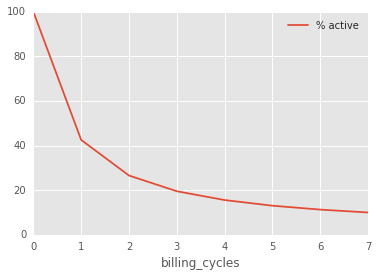

In [252]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( [ 'billing_cycles'] ).size()}).reset_index()
user_count = len(df_data_1.user_id.unique())

#number of subscribers that has left

df_data_overall['# churners'] = df_data_overall['count'].cumsum()

#number of subscribers still active

df_data_overall['# active'] = user_count - df_data_overall['# churners']

# Adding the month 0 to the dataframe

df_data_overall_0 = pd.DataFrame({'billing_cycles': [0],'# churners': [0],'# active': [user_count] , 'count' : [user_count]})

df_data_overall = df_data_overall_0.append(df_data_overall,ignore_index=True)

# number of active subscribers normalized (%)

df_data_overall['% active'] = df_data_overall['# active']/user_count*100

# churn rate 

df_data_overall['churn rate'] = df_data_overall['count']/df_data_overall['# active'].shift(1)

# retention rate

df_data_overall['retention rate'] = 1 - df_data_overall['churn rate']

df_data_overall.plot(x = 'billing_cycles',y = '% active')
#plt.axes.tick_params(axis='x', labelsize=10)
#df_data_overall['retention rate'].plot()

On top of the % active users, we are interested to study how the revenue are distributed between price plans. Usually we observe that the 20% of the subscribers are generating 80% of the revenues (usually the highest revenue segment). It is known as the Pareto law. Here the results are different

In [253]:
df_sub = pd.DataFrame({'count' : df_data_1.groupby( ['billing_cycles','subscription_monthly_cost'] ).size()}).reset_index()
df_sub['revenue'] = df_sub['count']*df_sub['billing_cycles']*df_sub['subscription_monthly_cost']

pyramid = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
pyramid['revenue since start'] = df_sub.groupby(['subscription_monthly_cost']).sum().reset_index()['revenue']
pyramid['user count last month'] = df_sub.loc[lambda df: df.billing_cycles == 8].reset_index()['count']
pyramid['revenue last month'] = pyramid['user count last month']*pyramid['subscription_monthly_cost']

total = pyramid.sum()

pyramid['user_count %'] = pyramid['user_count'] / total['user_count'] 
pyramid['revenue since start %'] = pyramid['revenue since start'] / total['revenue since start']
pyramid['user count last month %'] = pyramid['user count last month']  / total['user count last month']
pyramid['revenue last month %'] = pyramid['revenue last month'] / total['revenue last month']


pyramid = pyramid.sort_values(['subscription_monthly_cost'],ascending=False)

pyramid_cum = pyramid.groupby('subscription_monthly_cost').sum().sort_index(ascending=False).cumsum().add_suffix('_cum').reset_index()

pyramid = pd.merge(pyramid,pyramid_cum,on='subscription_monthly_cost')
pyramid

,subscription_monthly_cost,user_count,revenue since start,user count last month,revenue last month,user_count %,revenue since start %,user count last month %,revenue last month %,user_count_cum,revenue since start_cum,user count last month_cum,revenue last month_cum,user_count %_cum,revenue since start %_cum,user count last month %_cum,revenue last month %_cum
0,99,53241,7147404,799,79101,0.106482,0.138333,0.015980,0.043961,53241.0,7147404.0,799.0,79101.0,0.106482,0.138333,0.015980,0.043961
1,49,300397,29479331,14673,718977,0.600794,0.570551,0.293466,0.399574,353638.0,36626735.0,15472.0,798078.0,0.707276,0.708884,0.309446,0.443534
2,29,146362,15041430,34527,1001283,0.292724,0.291116,0.690554,0.556466,500000.0,51668165.0,49999.0,1799361.0,1.000000,1.000000,1.000000,1.000000



## 3. Modeling

What exactly are we predicting? we are predicting the monthly retention rate (i.e. how many subscribers did you keep / number of subscribers still there last month).
We compute the KPIs for all the subscription monthly cost (same computation as above except that it is done for each cost)

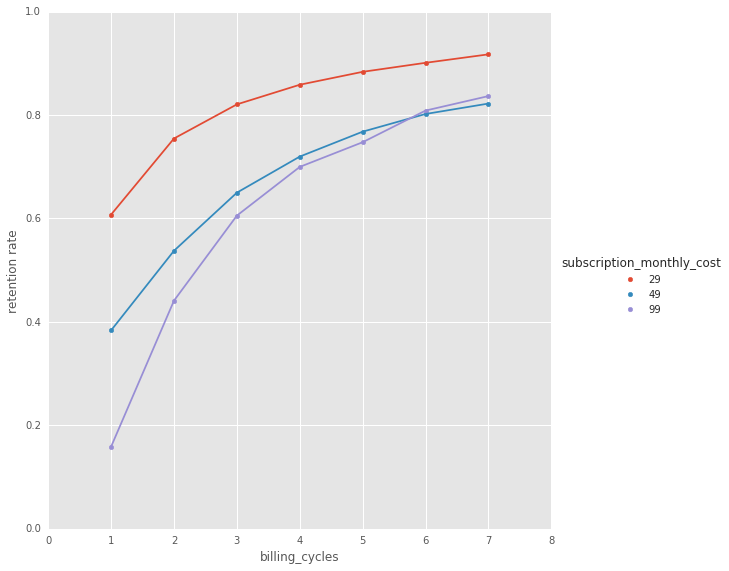

In [254]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['subscription_monthly_cost','billing_cycles'] ).size()}).reset_index()

df = df_data_overall.groupby(['subscription_monthly_cost','billing_cycles'] ).sum().groupby(level=[0]).cumsum()
df = df.add_suffix('_cumsum').reset_index()
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()}).reset_index()
df = pd.merge(df, user_count, how='inner', on='subscription_monthly_cost')

df = df.rename(columns={"count_cumsum": "# churners"})

df['# active'] = df['user_count'] - df['# churners']

# Adding the month 0 to the dataframe

df_0 = pd.DataFrame({'billing_cycles': [0,0,0],'# churners': [0,0,0],'subscription_monthly_cost' : user_count['subscription_monthly_cost'],'# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

df = df_0.append(df,ignore_index=True)

# number of active subscribers normalized (%)

df['% active'] = df['# active']/df['user_count']*100

# churn rate 

df = df.sort_values(['subscription_monthly_cost','billing_cycles'])

df['churn rate'] = (df['# churners']-df['# churners'].shift(1))/df['# active'].shift(1)

# retention rate

df['retention rate'] = 1 - df['churn rate']

df = df.join(pd.get_dummies(df['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))


#Bayesian prior -- I'll explain later
df_end = pd.DataFrame({'billing_cycles': [100,100,100],'retention rate' :[1,1,1],'subscription_monthly_cost':['29','49','99'],'subscription_monthly_cost_29':[1,0,0],'subscription_monthly_cost_49':[0,1,0],'subscription_monthly_cost_99':[0,0,1]})


# Make the cost a string and a category
df['subscription_monthly_cost'] = df['subscription_monthly_cost'].apply(str).astype('category')

g = sns.FacetGrid(df.loc[lambda df: df.billing_cycles != 0], hue='subscription_monthly_cost', size=8,xlim = [0,8],ylim = [0,1])
g.map(plt.scatter, "billing_cycles", "retention rate")
g.map(plt.plot, "billing_cycles", "retention rate").add_legend()


plt.show()

**Time to run the first models** - Our first choice goes to the shifted Beta Geometric distribution that has shown very interesting results for retention predictions (Hardie). Note that we are modeling with the raw data almost (at the individual level). We are just adding the flag variables for the different subscription monthly cost.

In [255]:
#the feature are the one-hot encoding of the costs
feature_list = ['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99']

data = df_data_1[['is_active','billing_cycles','subscription_monthly_cost']].join(pd.get_dummies(df_data_1['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))

# Make the cost a string and a category
data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')


#separate training and testing data
train, test = train_test_split(data, test_size = 0.2)

# define the model with a gamma (~learning rate) low
sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=feature_list,gamma=1e-3,verbose=True)

# Train model
sbs.fit(data)

# Summary of results
print(sbs.summary())

Starting Optimization with parameters:
        Samples: 500000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:50   |  656516.10484 |

Optimization completed:
             wa: [ 0.2077607  -0.26631185  0.15303059  0.07681231]
             wb: [-0.13277738  0.14409383  0.14404667 -0.29511634]
  LogLikelihood: 656516.1048405329
   Reg. Penalty: 0.00022884662152910747

                               w_alpha    w_beta
bias                          0.207761 -0.132777
subscription_monthly_cost_29 -0.266312  0.144094
subscription_monthly_cost_49  0.153031  0.144047
subscription_monthly_cost_99  0.076812 -0.295116



**Now that we have a model** we want to compare its results with the actual values first visually and then analytically (accuracy)

Accuracy
[ 0.999023    0.98727442  0.97738807]


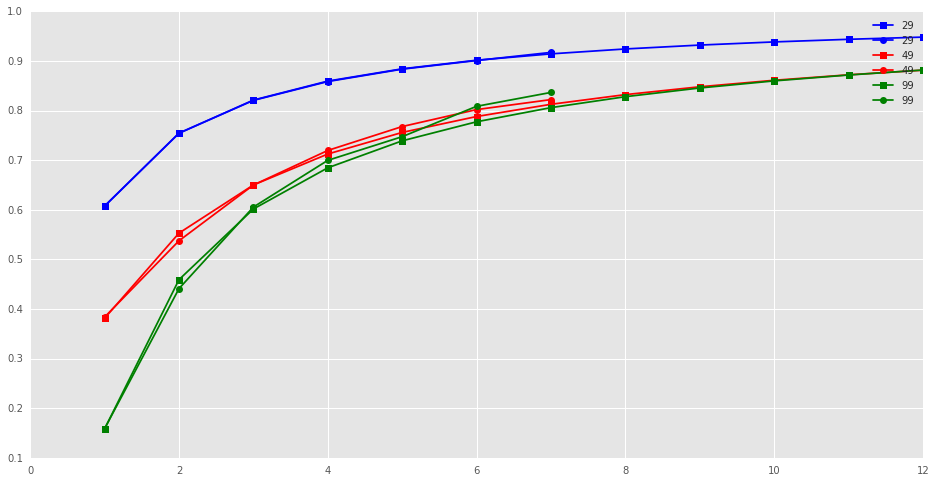

In [256]:
pred_train = train.reset_index().join([sbs.predict_churn(train, age=1, n_periods=13)])
pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])

f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {'29': 'b', '49': 'r', '99': 'g'}



# we do not plot the training data    
for name, df1 in pred_train.groupby('subscription_monthly_cost'):
    inter_churn_gross = df1.mean().values[7:]
    inter_prop_active = 1-np.roll(np.cumsum(df1.mean().values[7:]),1)
    inter_prop_active[0] = 1
    int_retention = 1 - inter_churn_gross/inter_prop_active
    #axis.plot(int_retention, alpha=1, c=col_map[name], label=name,marker="_")

accuracy = np.zeros(3)    
i = 0    

for name, df1 in pred_test.groupby('subscription_monthly_cost'):
    inter_churn_gross = df1.mean().values[7:7+12]
    inter_prop_active = 1-np.roll(np.cumsum(df1.mean().values[7:7+12]),1)
    inter_prop_active[0] = 1
    int_retention = 1 - inter_churn_gross/inter_prop_active
    
    axis.plot(range(1,13),int_retention, alpha=1, c=col_map[name], label=name,marker = "s")
    actual = df.loc[lambda df: (df.subscription_monthly_cost==name)]['retention rate'].values[1:8]
    #axis.plot(df.loc[lambda df: (df.subscription_monthly_cost==name)]['retention rate'].values[1:8], alpha=1, c=col_map[name], label=name,marker='o')
    axis.plot(range(1,8),actual, alpha=1, c=col_map[name], label=name,marker='o')
    accuracy[i] = np.mean(1-np.abs(actual-int_retention[0:7])/actual)
    i = i+1


print("Accuracy")
print(accuracy)
    
plt.legend()

Question? Does the 99 model fits better when only 99 are in the data? (should not be the case)

Starting Optimization with parameters:
        Samples: 53241
  gamma (alpha): 0.1
   gamma (beta): 0.1
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:00:00   |   34889.05175 |

Optimization completed:
             wa: [ 0.41385934]
             wb: [-1.25706423]
  LogLikelihood: 34889.05174667547
   Reg. Penalty: 0.0

       w_alpha    w_beta
bias  0.413859 -1.257064

Accuracy is: 0.977389340823


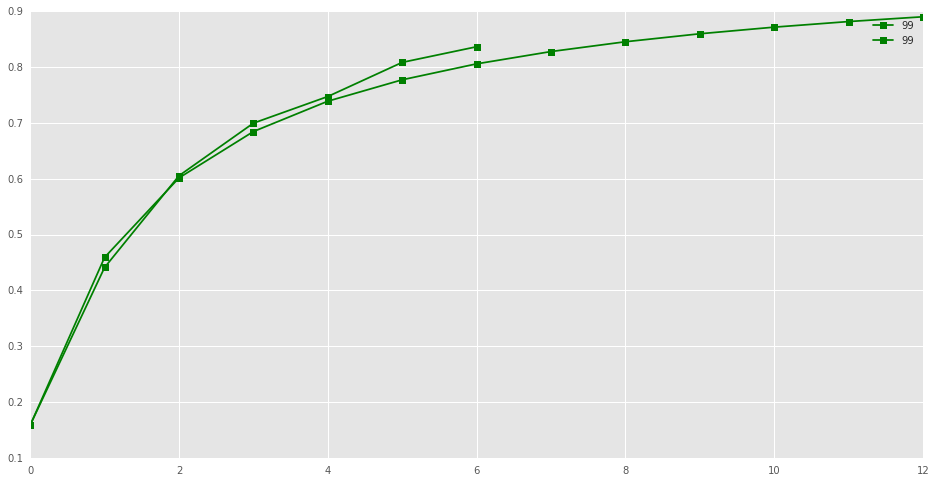

In [51]:
from sklearn.model_selection import train_test_split

data = df_data_1.loc[lambda df: df.subscription_monthly_cost == 99][['is_active','billing_cycles']]

train, test = train_test_split(data, test_size = 0.2)

sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=None,gamma=0.1,verbose=True)

# Train model
sbs.fit(data)
# Summary of results
print(sbs.summary())

pred_test_99 = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])

f, axis = plt.subplots(1, 1, figsize=(16, 8))

#axis.plot(df.loc[lambda df: (df.subscription_monthly_cost=='99')]['retention rate'].values[1:8], alpha=1, c=col_map['99'], label='99',marker='o')


inter_churn_gross = pred_test_99.mean().values[3:]
#print(inter_churn_gross)
inter_prop_active = 1-np.roll(np.cumsum(pred_test_99.mean().values[3:]),1)
inter_prop_active[0] = 1
int_retention = 1 - inter_churn_gross/inter_prop_active
actual = df.loc[lambda df: (df.subscription_monthly_cost=='99')]['retention rate'].values[1:8]
accuracy_99 = np.mean(1-np.abs(actual-int_retention[0:7])/actual)
axis.plot(int_retention, alpha=1, c=col_map['99'], label='99',marker="s")
axis.plot(actual, alpha=1, c=col_map['99'], label='99',marker="s")
    
plt.legend()

print("")
print("Accuracy is: "+str(accuracy_99))

## 3bis. Modeling with MLP

We observe very good results for the sBG model. However we would like to try a totally non-parametric approach on the retention rate directly (not at the individual level). We are going to fit a simple MLP (one hidden layer) on the data. Note that we have to balance our data many times in order to feed enough data to the model.
The data had been defined earlier. We added a prior that all the retention rate would reach 100 at the time 100, in order to force the MLP not to go above.

In [60]:
df_train = df_end.append(df,ignore_index=True)
df_train = df_train[lambda df: ((df.billing_cycles>0))]

X_train = pd.concat([df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]]*10000).values
Y_train = pd.concat([df_train['retention rate']]*10000).values

Fit the model

In [65]:
from sklearn.neural_network import MLPRegressor
Model = MLPRegressor(hidden_layer_sizes=(5, ), activation='tanh', solver='adam', alpha=0.001,learning_rate = 'adaptive', learning_rate_init=0.001,max_iter=20000)
Model.fit(X_train,Y_train)

#print(Model.predict(df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]))
#print(df_train['retention rate'])

MLPRegressor(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=20000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

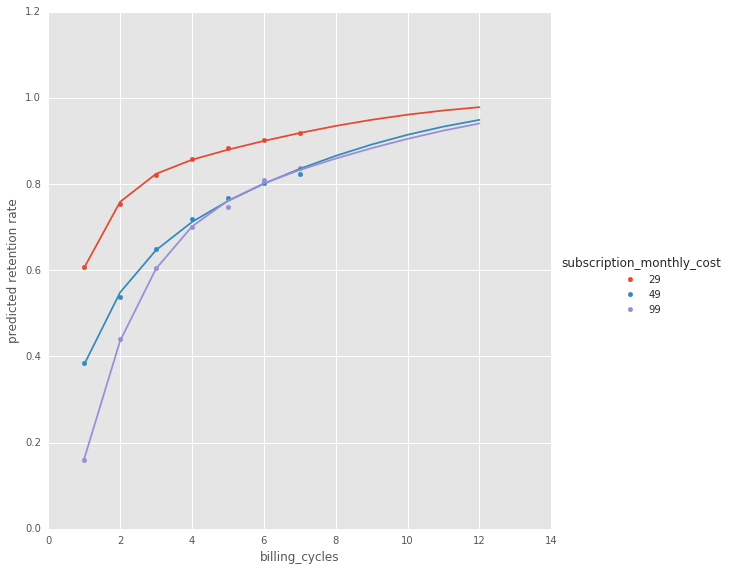

In [390]:
df_future = pd.DataFrame({'billing_cycles': [8, 9, 10, 11, 12, 8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
                     'subscription_monthly_cost' : ['29','29','29','29','29','49','49','49','49','49','99','99','99','99','99']})

df_predict = df_future.append(df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost','% active']],ignore_index=True)
df_predict = df_predict.join(pd.get_dummies(df_predict['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_')).sort_values(['subscription_monthly_cost','billing_cycles'])

df_predict['predicted retention rate'] = Model.predict(df_predict[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']])

df_predict = pd.merge(df_predict, df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost','retention rate']], how='left', on=['billing_cycles','subscription_monthly_cost'])

g = sns.FacetGrid(df_predict, hue='subscription_monthly_cost', size=8)
g.map(plt.scatter, "billing_cycles", "retention rate")
#g.map(plt.plot, "billing_cycles", "retention rate").add_legend()
g.map(plt.plot, "billing_cycles", "predicted retention rate").add_legend()


plt.show()

In [394]:
accuracy_df = pd.merge(df_predict[lambda df: df.billing_cycles<8][['predicted retention rate','billing_cycles','subscription_monthly_cost']],df_train[lambda df: df.billing_cycles<8][['retention rate','billing_cycles','subscription_monthly_cost']],how='left', on=['billing_cycles','subscription_monthly_cost'])
accuracy_df['accuracy'] = (1 - np.abs(accuracy_df['predicted retention rate']-accuracy_df['retention rate'])/accuracy_df['retention rate'])
accuracy_df.groupby(['subscription_monthly_cost']).mean()

,predicted retention rate,billing_cycles,retention rate,accuracy
subscription_monthly_cost,,,,
29,0.820205,4,0.820469,0.996931
49,0.669169,4,0.668986,0.990040
99,0.613964,4,0.613990,0.990213


## 4. How to use the results?

We can compute all the predicted KPIs until month 12 (especially % active subscribers left).

On top of that, we are very interested to understand the dynamic of revenues per subscription plan.

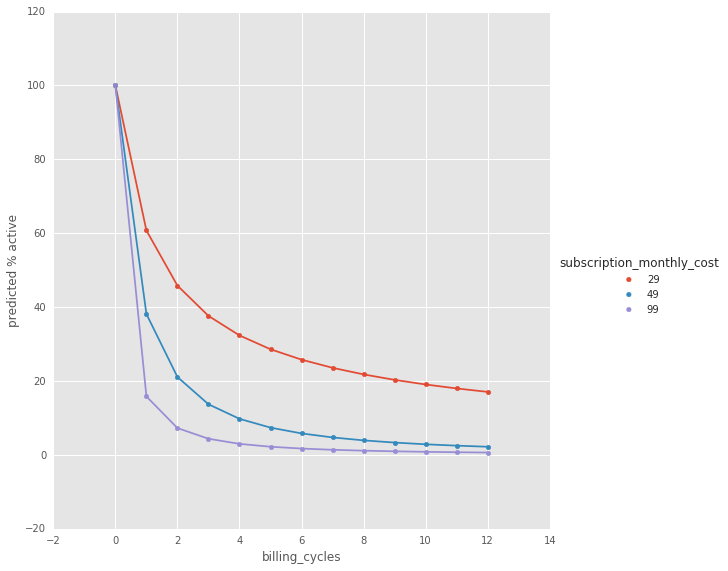

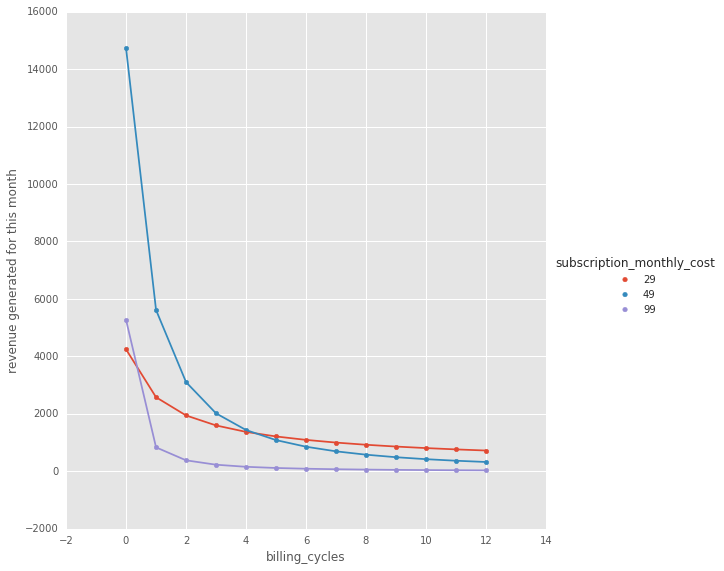

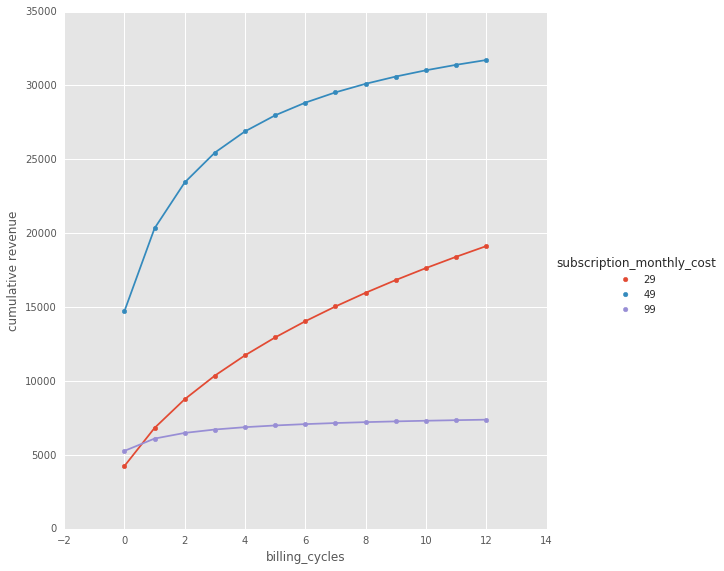

In [174]:
#the output is where all the predicted results are stored

output = pd.DataFrame({'billing_cycles': np.tile(range(1,13), 3),
                       'subscription_monthly_cost' : np.repeat(['29','49','99'],12), 
                       'predicted gross churn' : pred_test.groupby('subscription_monthly_cost').mean().values[:,6:6+12].reshape(12*3),
                       'user_count' : np.repeat(df_data_1.groupby(['subscription_monthly_cost']).size(),12)})



df_0 = pd.DataFrame({'billing_cycles': [0,0,0],
                     'subscription_monthly_cost' : ['29','49','99'],
                     'predicted gross churn': [0,0,0],
                     'user_count' : df_data_1.groupby(['subscription_monthly_cost']).size()})


output = df_0.append(output,ignore_index=True)
output = output.sort_values(['subscription_monthly_cost','billing_cycles'])


output['predicted % active'] = (1 - output.groupby(['subscription_monthly_cost','billing_cycles']).sum().groupby(level = [0]).cumsum()['predicted gross churn'].values)*100
output.ix[output.billing_cycles == 0,'predicted % active']=100
output['predicted # active'] = output['predicted % active']*output['user_count']/100
output['predicted # churners'] = output['user_count'] - output['predicted # active']
output['predicted retention rate'] = 1 - output['predicted gross churn']/(output['predicted % active']/100)
output['predicted churn rate'] = 1-output['predicted retention rate']
output.subscription_monthly_cost = pd.to_numeric(output.subscription_monthly_cost)



#plot the % subscribers left over time

g = sns.FacetGrid(output, hue='subscription_monthly_cost', size=8)
g.map(plt.scatter, "billing_cycles", "predicted % active")
#g.map(plt.plot, "billing_cycles", "retention rate").add_legend()
g.map(plt.plot, "billing_cycles", "predicted % active").add_legend()


plt.show()  



#After all the KPIs have been computed we can relate that to revenue numbers
output['revenue loss (k)'] = output['subscription_monthly_cost']*output['predicted # churners']/1000
output['revenue at risk this month (k)'] = (output['revenue loss (k)'] - output['revenue loss (k)'].shift(1))
output.ix[output.billing_cycles == 1,'revenue at risk this month (k)'] = output.ix[output.billing_cycles == 1,'revenue loss (k)']
output['revenue generated for this month'] = output['predicted # active']*output['subscription_monthly_cost']/1000
output['cumulative revenue'] = output.groupby(['subscription_monthly_cost','billing_cycles']).sum().groupby(level = [0]).cumsum()['revenue generated for this month'].values


#Two trends are important to visualize: 1) the revenue per month and which plan is bringing the most revenue in the future 2) The cumulative revenues to see which plan is bringing the most revenue in the long term

g = sns.FacetGrid(output, hue='subscription_monthly_cost', size=8)
g.map(plt.scatter, "billing_cycles", "revenue generated for this month")
#g.map(plt.plot, "billing_cycles", "retention rate").add_legend()
g.map(plt.plot, "billing_cycles", "revenue generated for this month").add_legend()


plt.show()        

g = sns.FacetGrid(output, hue='subscription_monthly_cost', size=8)
g.map(plt.scatter, "billing_cycles", "cumulative revenue")
#g.map(plt.plot, "billing_cycles", "retention rate").add_legend()
g.map(plt.plot, "billing_cycles", "cumulative revenue").add_legend()


plt.show()

## 5. Confidence Interval Generatation (bootstrop)

### For the sBG

In [395]:
predicted_bootstrap_alpha_beta = np.zeros((100,3,13))

feature_list = ['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99']

for i in range(0, 100):
    #print(i)
    df_bootstrap = resample(df_data_1, n_samples=len(df_data_1))



    # measured percentage of cohort that survives over time
    data = df_bootstrap[['is_active','billing_cycles','subscription_monthly_cost']].join(pd.get_dummies(df_data_1['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))

    data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')

    train, test = train_test_split(data, test_size = 0.2)


    sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=feature_list,gamma=1e-3,verbose=False)

    # Train model
    sbs.fit(data)
    
    
    pred_train = train.reset_index().join([sbs.predict_churn(train, age=1, n_periods=13)])
    pred_test = test.reset_index().join([sbs.predict_churn(test, age=1, n_periods=13)])
    #print(pred_test.shape)
    
    #predicted_bootstrap_alpha_beta[i,0,:] = pred_train
    predicted_bootstrap_alpha_beta[i,0,:] = pred_test.groupby('subscription_monthly_cost').mean().values[0,6:]
    predicted_bootstrap_alpha_beta[i,1,:] = pred_test.groupby('subscription_monthly_cost').mean().values[1,6:]
    predicted_bootstrap_alpha_beta[i,2,:] = pred_test.groupby('subscription_monthly_cost').mean().values[2,6:]

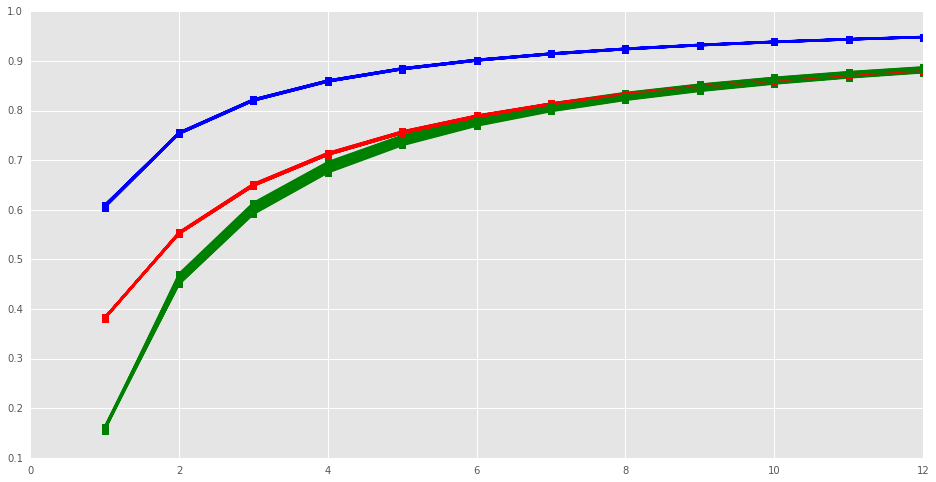

In [185]:
retention_bootstrap = np.zeros((100,3,12))

f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {0: 'b', 1: 'r', 2: 'g'}
price_map = {0: '29', 1: '49', 2: '99'}

for i in range(0,100):
    for j in range(0,3):
        inter_churn_gross = predicted_bootstrap_alpha_beta[i,j,0:12]
        inter_prop_active = 1-np.roll(np.cumsum(predicted_bootstrap_alpha_beta[i,j,0:12]),1)
        inter_prop_active[0] = 1
        int_retention = 1 - inter_churn_gross/inter_prop_active
        retention_bootstrap[i,j,:] = int_retention
        
        axis.plot(range(1,13),int_retention, alpha=1, c=col_map[j], label=name,marker = "s")

In [194]:
l = round(0.025*len(retention_bootstrap[:,0,0]))
h = round(0.975*len(retention_bootstrap[:,0,0]))

lowerconfidence = np.sort(retention_bootstrap[:,:,:], axis=0)[l,:,:]
higherconfidence = np.sort(retention_bootstrap[:,:,:], axis=0)[h,:,:]

print(lowerconfidence)
print(higherconfidence)

[[ 0.60467841  0.75273587  0.81985525  0.85820952  0.8830644   0.90050516
   0.91341863  0.9233651   0.93126176  0.93768305  0.94300713  0.94749309]
 [ 0.37982527  0.5513567   0.64822883  0.71050227  0.7540778   0.78630198
   0.81104629  0.83066159  0.84658736  0.8597751   0.87087501  0.88034653]
 [ 0.15525472  0.45073794  0.59264962  0.67628674  0.73142958  0.77052024
   0.79967737  0.82226052  0.84026775  0.85496192  0.86718033  0.87750007]]
[[ 0.60954032  0.7557157   0.8228926   0.8611106   0.88576202  0.90298174
   0.91569022  0.92545493  0.93319253  0.93947489  0.94467726  0.94905609]
 [ 0.38296055  0.55476354  0.65230867  0.71479346  0.75824083  0.79020089
   0.8146975   0.83407166  0.849778    0.86276802  0.8736903   0.88300214]
 [ 0.16174315  0.46948423  0.61293152  0.69531575  0.74878477  0.78628891
   0.81404961  0.83542732  0.85239649  0.86619336  0.87763146  0.88726804]]


### For the MLP

In [ ]:
predicted_bootstrap = np.zeros((100,2,12*3))

for i in range(0, 100):
    print(i)
    df_bootstrap = resample(df_data_1, n_samples=len(df_data_1))
    df = pd.DataFrame({'count' : df_bootstrap.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost'] ).size()}).reset_index()
    df = df.groupby(['subscription_monthly_cost','billing_cycles'] ).sum().groupby(level=[0]).cumsum()
    df = df.add_suffix('_cumsum').reset_index()
    user_count = pd.DataFrame({'user_count' : df_bootstrap.groupby(['subscription_monthly_cost']).size()}).reset_index()
    df = pd.merge(df, user_count, how='inner', on='subscription_monthly_cost')
    df = df.rename(columns={"count_cumsum": "# churners"})

    df['# active'] = df['user_count'] - df['# churners']

    # Adding the month 0 to the dataframe

    df_0 = pd.DataFrame({'billing_cycles': [0,0,0],'# churners': [0,0,0],'subscription_monthly_cost' : user_count['subscription_monthly_cost'],'# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

    df = df_0.append(df,ignore_index=True)

    # number of active subscribers normalized (%)

    df['% active'] = df['# active']/df['user_count']*100

    # churn rate 

    df = df.sort_values(['subscription_monthly_cost','billing_cycles'])

    df['churn rate'] = (df['# churners']-df['# churners'].shift(1))/df['# active'].shift(1)

    # retention rate

    df['retention rate'] = 1 - df['churn rate']

    df = df.join(pd.get_dummies(df['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))
    
    df_end = pd.DataFrame({'billing_cycles': [100,100,100],'retention rate' :[1,1,1],'subscription_monthly_cost':[29,49,99],'subscription_monthly_cost_29':[1,0,0],'subscription_monthly_cost_49':[0,1,0],'subscription_monthly_cost_99':[0,0,1]})
    
    #print(df_end)
    df_train = df_end.append(df,ignore_index=True)
    #print(df.head())
    
    #df_train = df_train[lambda df: ((df.billing_cycles>0) & (df.billing_cycles != 7))]
    df_train = df_train[lambda df: ((df.billing_cycles>0))]
    X_train = pd.concat([df_train[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']]]*20000).values
    Y_train = pd.concat([df_train['retention rate']]*20000).values
    
    from sklearn.neural_network import MLPRegressor
    Model = MLPRegressor(hidden_layer_sizes=(5, ), activation='tanh', solver='adam', alpha=0.001,learning_rate = 'constant', learning_rate_init=0.01,max_iter=40000)
    Model.fit(X_train,Y_train)
    
    df_future = pd.DataFrame({'billing_cycles': [8, 9, 10, 11, 12, 8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
                     'subscription_monthly_cost' : [29,29,29,29,29,49,49,49,49,49,99,99,99,99,99]})

    df_predict = df_future.append(df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost']],ignore_index=True)
    df_predict = df_predict.join(pd.get_dummies(df_predict['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_')).sort_values(['subscription_monthly_cost','billing_cycles'])

    df_predict['predicted retention rate'] = Model.predict(df_predict[['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','billing_cycles']])

    df_predict = pd.merge(df_predict, df_train[lambda df: df.billing_cycles<100][['billing_cycles','subscription_monthly_cost','retention rate']], how='left', on=['billing_cycles','subscription_monthly_cost'])
    #print(df_predict)

    predicted_bootstrap[i,0,:] = df_predict['predicted retention rate']
    predicted_bootstrap[i,1,:] = df_predict['retention rate']
    

In [ ]:
df_mlp_bootstrap = pd.DataFrame({'predicted_bootstrap': predicted_bootstrap[:,0,24:36].reshape(-1,), 'actual_bootstrap': predicted_bootstrap[:,1,24:36].reshape(-1,)}).reset_index()

df_mlp_bootstrap['billing_cycles'] = (df_mlp_bootstrap['index'] % 12) + 1

df['bootstrap'] = df['index'] // 12


l = round(0.025*len(predicted_bootstrap[:,0,0]))
h = round(0.975*len(predicted_bootstrap[:,0,0]))

lowerconfidence = df[df['billing_cycles']== 12].sort_values(['predicted_bootstrap']).reset_index().ix[l,'predicted_bootstrap']
higherconfidence = df[df['billing_cycles']== 12].sort_values(['predicted_bootstrap']).reset_index().ix[h,'predicted_bootstrap']

print(lowerconfidence)
print(higherconfidence)

g = sns.FacetGrid(df_mlp_bootstrap, hue='bootstrap', size=8)
g.map(plt.plot, "billing_cycles", "predicted_bootstrap")

plt.show()

## 5. Insights for source and country

We would like to understand the difference in cohort decay for the different sources and the different countries

In [196]:
import plotly
plotly.tools.set_credentials_file(username='CyrilleDS', api_key='0vitnGQBJrqhSjT0BNS6')

df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost','country','source'] ).size()}).reset_index()

df = df_data_overall.groupby(['subscription_monthly_cost','country','source','billing_cycles'] ).sum().groupby(level=[0,1,2]).cumsum()
df = df.add_suffix('_cumsum').reset_index()


user_count_per_country = df_data_1.groupby(['country']).count().reset_index()[['country','user_id']]
user_count_per_country = user_count_per_country.rename(columns={"user_id": "country_count"})

user_count_per_source = df_data_1.groupby(['source']).count().reset_index()[['source','user_id']]
user_count_per_source = user_count_per_source.rename(columns={"user_id": "source_count"})

def active_percent_country(characteristic):
    user_country = user_count_per_country[lambda df: df.country == characteristic].values[0,1]
    active_percent = (user_country - df_data_overall[lambda df: df.country == characteristic].groupby(['billing_cycles']).sum().cumsum()['count'])/user_country*100
    active_percent[0] = 100
    active_percent.sort_values(inplace=True,ascending=False)
    return active_percent

def active_percent_source(characteristic):
    user_source = user_count_per_source[lambda df: df.source == characteristic].values[0,1]
    active_percent = (user_source - df_data_overall[lambda df: df.source == characteristic].groupby(['billing_cycles']).sum().cumsum()['count'])/user_source*100
    active_percent[0] = 100
    active_percent.sort_values(inplace=True,ascending=False)
    return active_percent
    

The plot below is interactive and can be visualize directly at https://plot.ly/~CyrilleDS/42


In [197]:
import plotly.plotly as py
from plotly.graph_objs import *

billing_cycles = [0, 1, 2, 3, 4, 5, 6, 7]


trace1 = Scatter(x=billing_cycles, y=active_percent_country('Germany'),line=Line(color='#C0C0C0',width=3),name='Germany')

trace2 = Scatter(x=billing_cycles, y=active_percent_country('France'),line=Line(color='#FFD700',width=3),name='France')

trace3 = Scatter(x=billing_cycles, y=active_percent_country('UK'),line=Line(color='#C0C0C0',width=3),name='UK')

trace4 = Scatter(x=billing_cycles, y=active_percent_country('US'),line=Line(color='#228b22',width=3),name='US')

trace5 = Scatter(x=billing_cycles, y=active_percent_country('India'),line=Line(color='#d2691e',width=3),name='India')

trace6 = Scatter(x=billing_cycles, y=active_percent_country('Italy'),line=Line(color='#9400d3',width=3),name='Italy')

trace7 = Scatter(x=billing_cycles, y=active_percent_country('Spain'),line=Line(color='#ff0000',width=3),name='Spain')

trace8 = Scatter(x=billing_cycles, y=active_percent_country('China'),line=Line(color='#191970',width=3),name='China')

trace9 = Scatter(x=billing_cycles,y=active_percent_source('seo'),line=Line(color='#8b7d6b',width=3),name='seo')

trace10 = Scatter(x=billing_cycles, y=active_percent_source('ads'),line=Line(color='#BA8651',width=3),name='ads')

trace11 = Scatter(x=billing_cycles, y=active_percent_source('friend_referral'),line=Line(color='#000000',width=3),name='friend_referral')


data = Data([trace1, trace2, trace3, trace4,trace5, trace6, trace7, trace8,trace9, trace10, trace11])
layout = Layout(
    title='Cohort Analysis',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, True, True, True,True,True,True,True,False,False,False]],
                    label='Country',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False,False,False,False,False,True,True,True]],
                    label='Source',
                    method='restyle'
                ),

            ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)

Although it is interesting to see the results broken down per country and source, we would like to see all the interactions together (country + source + price plan)

In [198]:
user_count = pd.DataFrame({'user_count' : df_data_1.groupby(['subscription_monthly_cost','country','source']).size()}).reset_index()
df = pd.merge(df, user_count, how='inner', on=['subscription_monthly_cost','country','source'])
df = df.rename(columns={"count_cumsum": "# churners"})

df['# active'] = df['user_count'] - df['# churners']

    # Adding the month 0 to the dataframe

df_0 = pd.DataFrame({'billing_cycles': np.zeros(72),'# churners': np.zeros(72),'subscription_monthly_cost' : user_count['subscription_monthly_cost'], 'country' : user_count['country'], 'source' : user_count['source'], '# active': user_count['user_count'] , 'user_count' : user_count['user_count']})

df = df_0.append(df,ignore_index=True)

    # number of active subscribers normalized (%)

df['% active'] = df['# active']/df['user_count']*100

In [200]:
from mpl_toolkits.axes_grid1 import AxesGrid

sns.set(font_scale=5)

g = sns.FacetGrid(df, hue='subscription_monthly_cost', col='country',  row='source', size=20,xlim = [0,7],ylim = [0,100])
g.map(plt.scatter, "billing_cycles", "% active",s=800)
g.map(plt.plot, "billing_cycles", "% active",linewidth=8.0).add_legend()

## 6. Customer Lifetime Value and Profit per subscriber


In [258]:
#the feature are the one-hot encoding of the costs
feature_list = ['subscription_monthly_cost_29','subscription_monthly_cost_49','subscription_monthly_cost_99','country','source']

data = df_data_1[['is_active','billing_cycles','subscription_monthly_cost','country','source']].join(pd.get_dummies(df_data_1['subscription_monthly_cost']).add_prefix('subscription_monthly_cost_'))

# Make the cost a string and a category
data['subscription_monthly_cost'] = data['subscription_monthly_cost'].apply(str).astype('category')
data['country'] = data['country'].astype('category')
data['source'] = data['source'].astype('category')


#separate training and testing data
train, test = train_test_split(data, test_size = 0.2)

# define the model with a gamma (~learning rate) low
sbs = SBGSurvival(age='billing_cycles', alive='is_active',features=feature_list,gamma=1e-3,verbose=True)

# Train model
sbs.fit(data)

# Summary of results
print(sbs.summary())

Starting Optimization with parameters:
        Samples: 500000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 |  0:13:19   |  621582.15104 |

Optimization completed:
             wa: [-0.14614941 -0.31068894  0.28453885  0.11131243  0.97231751 -1.14916499
  0.06928974 -1.22241724  0.54841031  0.09732846 -1.02930539  0.56839259
  0.57042663  0.17611017  0.16819417]
             wb: [ 0.10839089  0.1400987   0.35744336 -0.2510984   0.15104061 -0.44440753
  0.08705746 -1.05746532  0.19930286  0.37599453 -1.00612036  0.22138488
  0.22002783  0.45555189  0.43636191]
  LogLikelihood: 621582.1510445855
   Reg. Penalty: 0.009277725398953524

                               w_alpha    w_beta
bias                         -0.146149  0.108391
country_China                 0.972318  0.151041
country_France               -1.149165 -0.444408
country_Germany               0.069290  0.087057
country_India  

Calling the function life time value (ltv) to get the expected value from subscribers pre-acquisition

In [355]:
CLV = test.reset_index().join(sbs.predict_ltv(test, age=1,alive=1,arpu = 1,discount_rate = 0.01))

CLV.subscription_monthly_cost = pd.to_numeric(CLV.subscription_monthly_cost)

CLV['clv'] = CLV['ltv']*CLV['subscription_monthly_cost']

CLV_agg = CLV.groupby(['subscription_monthly_cost','country','source']).mean().reset_index()
CLV_agg['price + source'] = CLG_agg.subscription_monthly_cost.map(str) + " - " + CLG_agg.source.astype(str) 

plt.figure(figsize=(10,10))
CLV_mat = CLV_agg.pivot("price + source","country", "clv")
ax = sns.heatmap(CLV_mat)

Defining the different cost of acquisition per source, country and plan

/usr/local/src/conda3_runtime.v16/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/src/conda3_runtime.v16/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/src/conda3_runtime.v16/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/src/conda3_runtime.v16/4.1.1/lib/python3.5/site-packages/ipyk

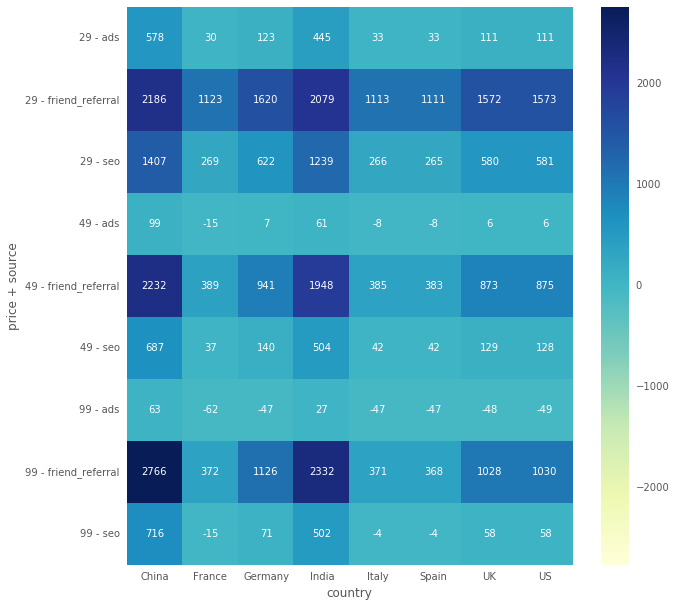

In [398]:
#CLV_agg['coeff_country'] = np.where(CLV['country'] == 'China' | CLV['country'] == 'India',0.5,np.where(CLV['country'] == 'Italy' | CLV['country'] == 'Spain',0.8,1))
CLV_agg['coeff_country'] = 1
CLV_agg['coeff_country'][(CLV_agg['country']=='China') | (CLV_agg['country'] == 'India')] = 0.5 
CLV_agg['coeff_country'][(CLV_agg['country']=='Spain') | (CLV_agg['country'] == 'Italy')] = 0.8 


CLV_agg['coeff plan'] =  CLV_agg['subscription_monthly_cost']/100

CLV_agg['acquisition cost'] = 75
CLV_agg['acquisition cost'][CLV_agg['source'] == 'seo'] = 60
CLV_agg['acquisition cost'][CLV_agg['source'] == 'friend_referral'] = 50

CLV_agg['acquisition cost'] = CLV_agg['acquisition cost']*CLV_agg['coeff_country']*CLV_agg['coeff plan']

CLV_agg['profit'] = (CLV_agg['clv'] - CLV_agg['acquisition cost']).astype(int)

np.set_printoptions(suppress=True)
plt.figure(figsize=(10,10))
CLV_mat = CLV_agg.pivot("price + source","country", "profit")
ax = sns.heatmap(CLV_mat,annot=True,cmap="YlGnBu",fmt='g')


In [370]:
CLV_mat

country,China,France,Germany,India,Italy,Spain,UK,US
price + source,,,,,,,,
29 - ads,578.922491,30.377205,123.759624,445.624906,33.897051,33.640512,111.696192,111.596890
29 - friend_referral,2186.974437,1123.022323,1620.027954,2079.791069,1113.609812,1111.111693,1572.480692,1573.766844
29 - seo,1407.035185,269.303945,622.936770,1239.347649,266.691176,265.410252,580.615348,581.563672
49 - ads,99.488561,-15.639809,7.545920,61.821456,-8.328773,-8.408035,6.460560,6.087337
49 - friend_referral,2232.435029,389.563280,941.224820,1948.576870,385.291257,383.361522,873.522067,875.052459
49 - seo,687.106115,37.626814,140.388676,504.046123,42.854328,42.557579,129.320777,128.751486
99 - ads,63.533894,-62.261923,-47.939728,27.230532,-47.448919,-47.495516,-48.827338,-49.026482
99 - friend_referral,2766.992663,372.591038,1126.261553,2332.664066,371.216221,368.893080,1028.563248,1030.297218
99 - seo,716.645785,-15.943374,71.064653,502.819044,-4.705456,-4.920964,58.751509,58.651207


## Bonus

In [373]:
df_data_overall = pd.DataFrame({'count' : df_data_1.loc[lambda df: df.is_active < 1].groupby( ['billing_cycles','subscription_monthly_cost','country'] ).size()}).reset_index()
df = df_data_overall.groupby(['subscription_monthly_cost','country','billing_cycles'] ).sum().groupby(level=[0,1]).cumsum()
df = df.add_suffix('_cumsum').reset_index()
df = df[lambda df: df.billing_cycles == 7]
df['revenue loss since start (k)'] = df['count_cumsum']*df['subscription_monthly_cost']/1000
#print(df[lambda df: df.subscription_monthly_cost == 29])
Revenue_loss_per_country = df.groupby(['country']).sum().reset_index()

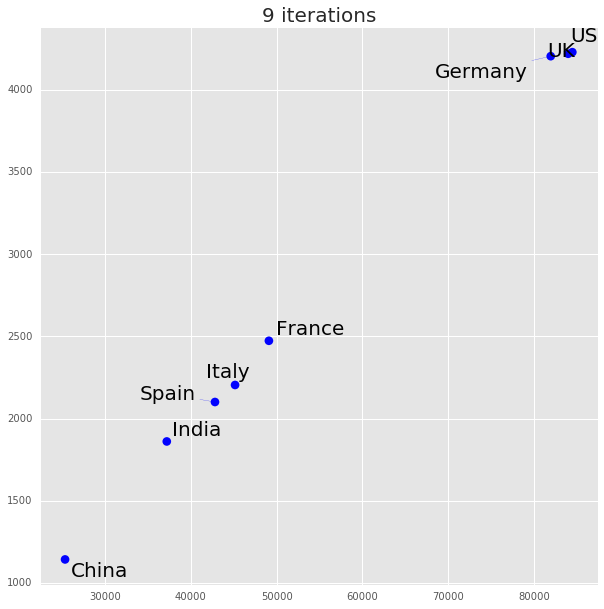

In [374]:
from adjustText import adjust_text
def plot_scatter(xy,label, alpha=0.25, figsize=(2,2), s=0.5, cmap='gist_rainbow',adjust=True):
    plt.figure(figsize=figsize, facecolor='white')
    plt.margins(0)
    #plt.axis('off')
    fig = plt.scatter(xy[:,0], xy[:,1],
                cmap=cmap, # set color map of markers
                alpha=alpha, # set alpha of markers
                marker=".", # use smallest available marker (square)
                s=s, # set marker size. single pixel is 0.5 on retina, 1.0 otherwise
                lw=0, # don't use edges
                edgecolor='') # don't use edges
    # remove all axes and whitespace / borders
    fig.axes.get_xaxis().set_visible(True)
    fig.axes.get_yaxis().set_visible(True)
    fig.axes.tick_params(axis='x', labelsize=10)
    fig.axes.tick_params(axis='y', labelsize=10)
    #for i, txt in enumerate(df_data_1.ix[:,4][0:100]):
        #plt.annotate(txt[0:100], (xy[i,0],xy[i,1]),xytext=(xy[i,0]+0.5, xy[i,1]+0.5),arrowprops=dict(arrowstyle="->"),size=10)
    texts = []
    for x, y, s in zip(xy[:,0], xy[:,1], label):
        texts.append(plt.text(x, y, s, size=20,color='black'))
    if adjust:
        plt.title(str(adjust_text(texts, arrowprops=dict(arrowstyle="-", color='b', lw=0.2)))+' iterations',size = 20)
    #plt.colorbar()
    #tick.label.set_fontsize(14)
    plt.show()
    
plot_scatter(Revenue_loss_per_country.ix[:,['count_cumsum','revenue loss since start (k)']].values,Revenue_loss_per_country.ix[:,'country'].values,alpha=3,figsize=(10,10), s = 300)